In [500]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from datetime import datetime

<b color='blue'> Загружаем данные и необходимые библиотеки</b>

In [572]:
df = pd.read_csv('SUM_DATA.csv')
# df = pd.read_csv('data.csv')

In [502]:
df = df.drop('STORE', axis=1)

In [503]:
df.head()

,SALE_DT,SALES
0,2019-01,6.116698e+08
1,2019-02,6.254852e+08
2,2019-03,7.278651e+08
3,2019-04,6.499091e+08
4,2019-05,6.118044e+08


## Data Cleaning

In [504]:
df.columns = ['Month', 'Sales']
df.head()

,Month,Sales
0,2019-01,6.116698e+08
1,2019-02,6.254852e+08
2,2019-03,7.278651e+08
3,2019-04,6.499091e+08
4,2019-05,6.118044e+08


In [532]:
df.shape

(42, 3)

There are 1 missing value in month and 2 values in sales column. We will drop them

In [507]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [508]:
df.tail()

,Month,Sales
37,2022-02,5.327292e+08
38,2022-03,7.537410e+08
39,2022-04,6.054326e+08
40,2022-05,5.480671e+08
41,2022-06,5.027106e+08


In [509]:
df.shape

(42, 2)

Month column contains date format so we will convert it to datetime datatype

In [510]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [511]:
df['Month'] = pd.to_datetime(df['Month'])

In [512]:
df.dtypes

Month    datetime64[ns]
Sales           float64
dtype: object

In [513]:
df.head()

,Month,Sales
0,2019-01-01,6.116698e+08
1,2019-02-01,6.254852e+08
2,2019-03-01,7.278651e+08
3,2019-04-01,6.499091e+08
4,2019-05-01,6.118044e+08


We will use month values as index value

In [514]:
df.set_index('Month', inplace=True)

In [515]:
df.head()

,Sales
Month,
2019-01-01,6.116698e+08
2019-02-01,6.254852e+08
2019-03-01,7.278651e+08
2019-04-01,6.499091e+08
2019-05-01,6.118044e+08


In [516]:
df.describe()

,Sales
count,4.200000e+01
mean,5.574131e+08
std,1.139248e+08
min,3.519605e+08
25%,4.789646e+08
50%,5.457878e+08
75%,6.101105e+08
max,8.893998e+08


## Visualizing Sales

Now we can visualize our data

seasonal data

<Axes: xlabel='Month'>

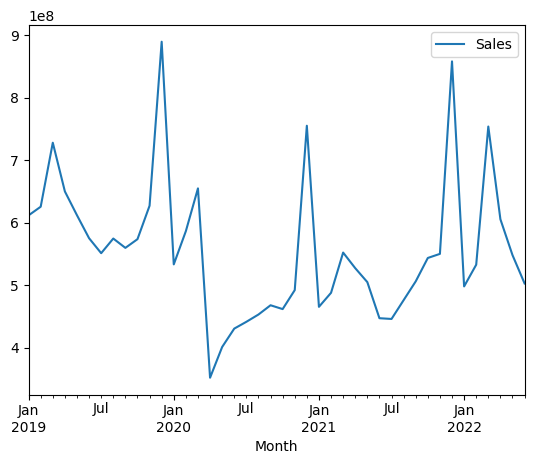

In [517]:
df.plot()

As seen below, our data is seasonal. Seasonality occurs when time series data exhibits regular and predictable patterns at time intervals that are smaller than a year.

## Checking for Stationarity

Data must be stationary for the time series use case.

**Stationarity** means the statistical properties of the data in a time series do not change over time. It’s a way to measure whether the data has structural patterns like seasonality/trends.

Why is it important to check for stationarity?

- Stationary data is much easier to analyze. 

- When forecasting future events, time series models assume that each point is independent of one others. Since stationary data contains no trends or seasonality, the data are considered independent of each other.

So we have to check for stationary before using ARIMA & SARIMAX.

**How can we identify stationary data?**

There are 2 statistical tests to check the time series data is stationary or not.

- **1- ADF - Augmented Dickey-Fuller Test**
- **2- Detrending/Differencing**

We will conduct Augmented Dickey-Fuller test to check if our data is stationary or not.

**How ADF test is conduct?**

- The ADF method in statsmodels will output the p-value, the value of the test statistics. If the test statistic is less than the critical value and the p-value is less than the alpha value you set (conventional alpha = 0.05), then there is enough evidence to reject the null hypothesis and state that the time series is stationary.

ADF test -> p-value < 0.05

### Conducting ADF Test

We will contuct ADF test with the following assumptions and hypotheses:

- **Null Hypothesis (H0)**: Data is not stationary.
- **Alternative Hypothesis (H1)**:  Data is stationary.

In [518]:
adfuller(df['Sales'])

(-4.821488413501406,
 4.946542437323099e-05,
 0,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 1245.739920785457)

In [519]:
def adfuller_test(sales):
    result = adfuller(sales)
    
    labels = ['ADF test statistics', 'p-value', 'Lags used', 'Number of obs used']
    
    for value, label in zip(result, labels):
        print('{} : {} '.format(label, value))
        
    if result[1]<=0.05:
        print('Strong evidence against null hypothesis, reject the null hypothesis and data is stationary')
    else:
        print('Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary')

In [520]:
adfuller_test(df['Sales'])

ADF test statistics : -4.821488413501406 
p-value : 4.946542437323099e-05 
Lags used : 0 
Number of obs used : 41 
Strong evidence against null hypothesis, reject the null hypothesis and data is stationary


As seen above, the p-value of the ADF test is greater than 0.05, so our data is not stationary. For time series use case we have to make our data stationary.

In [521]:
df

,Sales
Month,
2019-01-01,6.116698e+08
2019-02-01,6.254852e+08
2019-03-01,7.278651e+08
2019-04-01,6.499091e+08
2019-05-01,6.118044e+08
2019-06-01,5.750736e+08
2019-07-01,5.511557e+08
2019-08-01,5.745834e+08
2019-09-01,5.596533e+08


In [522]:
df['Sales'].shift(1)

Month
2019-01-01             NaN
2019-02-01    6.116698e+08
2019-03-01    6.254852e+08
2019-04-01    7.278651e+08
2019-05-01    6.499091e+08
2019-06-01    6.118044e+08
2019-07-01    5.750736e+08
2019-08-01    5.511557e+08
2019-09-01    5.745834e+08
2019-10-01    5.596533e+08
2019-11-01    5.735714e+08
2019-12-01    6.270833e+08
2020-01-01    8.893998e+08
2020-02-01    5.332384e+08
2020-03-01    5.864687e+08
2020-04-01    6.548460e+08
2020-05-01    3.519605e+08
2020-06-01    4.011334e+08
2020-07-01    4.305238e+08
2020-08-01    4.413847e+08
2020-09-01    4.530366e+08
2020-10-01    4.678771e+08
2020-11-01    4.617411e+08
2020-12-01    4.920891e+08
2021-01-01    7.550166e+08
2021-02-01    4.653435e+08
2021-03-01    4.877776e+08
2021-04-01    5.521452e+08
2021-05-01    5.271996e+08
2021-06-01    5.048700e+08
2021-07-01    4.471601e+08
2021-08-01    4.459584e+08
2021-09-01    4.760269e+08
2021-10-01    5.060857e+08
2021-11-01    5.435085e+08
2021-12-01    5.500617e+08
2022-01-01    8.579605

In [523]:
df['Sales first diff.'] = df['Sales'] - df['Sales'].shift(1)

In [524]:
df.head()

,Sales,Sales first diff.
Month,,
2019-01-01,6.116698e+08,NaN
2019-02-01,6.254852e+08,1.381540e+07
2019-03-01,7.278651e+08,1.023798e+08
2019-04-01,6.499091e+08,-7.795598e+07
2019-05-01,6.118044e+08,-3.810472e+07


We shift by 12 month cycle

In [525]:
df['Seasonal first diff.'] = df['Sales'] - df['Sales'].shift(12)

In [526]:
df.head()

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
2019-01-01,6.116698e+08,NaN,NaN
2019-02-01,6.254852e+08,1.381540e+07,NaN
2019-03-01,7.278651e+08,1.023798e+08,NaN
2019-04-01,6.499091e+08,-7.795598e+07,NaN
2019-05-01,6.118044e+08,-3.810472e+07,NaN


In [527]:
adfuller_test(df['Seasonal first diff.'].dropna())

ADF test statistics : -2.097711671011186 
p-value : 0.24543574514074784 
Lags used : 0 
Number of obs used : 29 
Weak evidence against null hypothesis, accept the null hypothesis and data is not stationary


Now our data is stationary 

<Axes: xlabel='Month'>

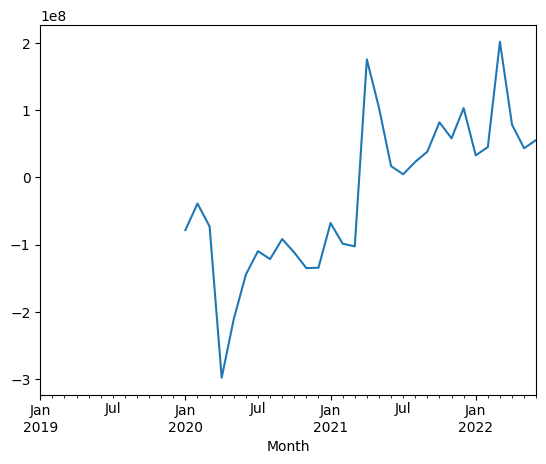

In [528]:
df['Seasonal first diff.'].plot()

## ARIMA

ARIMA is an acronym for “autoregressive integrated moving average.” It's a model used in statistics and econometrics to measure events that happen over a period of time. The model is used to understand past data or predict future data in a series.

In [529]:
df.head(15)

,Sales,Sales first diff.,Seasonal first diff.
Month,,,
2019-01-01,6.116698e+08,NaN,NaN
2019-02-01,6.254852e+08,1.381540e+07,NaN
2019-03-01,7.278651e+08,1.023798e+08,NaN
2019-04-01,6.499091e+08,-7.795598e+07,NaN
2019-05-01,6.118044e+08,-3.810472e+07,NaN
2019-06-01,5.750736e+08,-3.673080e+07,NaN
2019-07-01,5.511557e+08,-2.391781e+07,NaN
2019-08-01,5.745834e+08,2.342769e+07,NaN
2019-09-01,5.596533e+08,-1.493012e+07,NaN


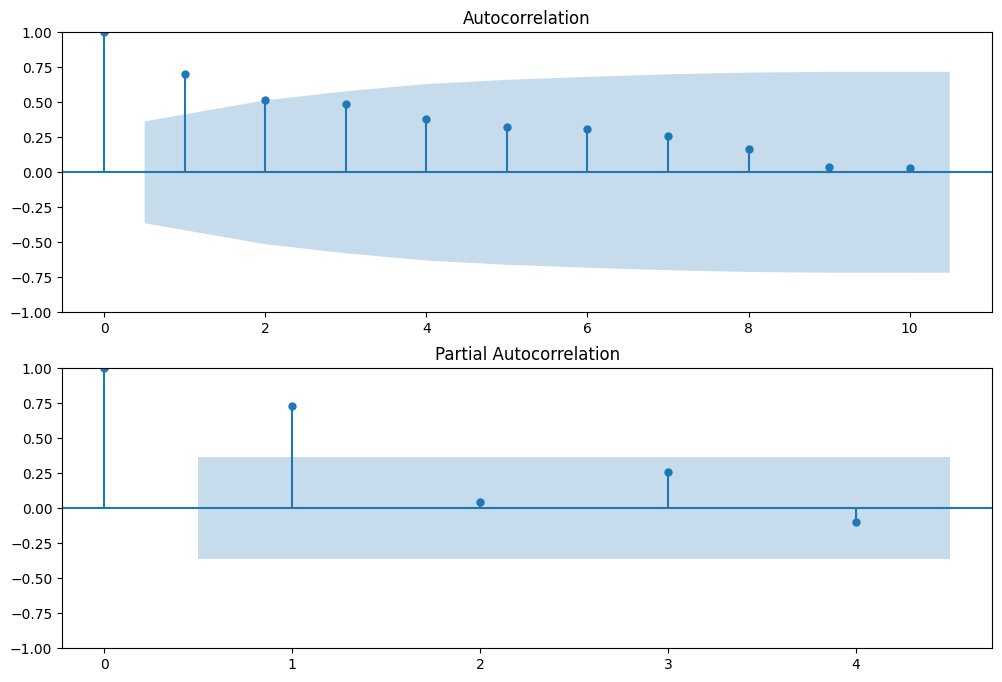

In [530]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal first diff.'].iloc[13:], lags=10, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal first diff.'].iloc[13:], lags=4, ax=ax2)

In [533]:
model = ARIMA(df['Sales'], order=(1,1,1))

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [534]:
model = model.fit()

In [535]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -568.867
Date:                            Fri, 28 Apr 2023   AIC                           1147.734
Time:                                    20:28:13   BIC                           1154.571
Sample:                                01-01-2019   HQIC                          1149.875
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0650      1.277      0.051      0.959      -2.438       2.568
ma.L1         -0.1451      1.251     -0.116      0.908      -2.596       2.306
ar.S.L12      -0.1967      0.581     -0.339      0.735      -1.335       0.941
ma.S.L12       0.0540      0.609      0.089      0.929      -1.140       1.248
sigma2      5.661e+15        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                15.43
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.31
Prob(H) (two-sided):                  0.38   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+48. Standard errors may be unstable.
"""

In [536]:
df.shape

(42, 3)

In [537]:
df['forecast'] = model.predict(start=35, end=42, dynamic=True)

In [538]:
df.tail(20)

,Sales,Sales first diff.,Seasonal first diff.,forecast
Month,,,,
2020-11-01,4.920891e+08,3.034795e+07,-1.349943e+08,NaN
2020-12-01,7.550166e+08,2.629275e+08,-1.343832e+08,NaN
2021-01-01,4.653435e+08,-2.896731e+08,-6.789488e+07,NaN
2021-02-01,4.877776e+08,2.243407e+07,-9.869116e+07,NaN
2021-03-01,5.521452e+08,6.436765e+07,-1.027008e+08,NaN
2021-04-01,5.271996e+08,-2.494566e+07,1.752391e+08,NaN
2021-05-01,5.048700e+08,-2.232959e+07,1.037366e+08,NaN
2021-06-01,4.471601e+08,-5.770991e+07,1.663631e+07,NaN
2021-07-01,4.459584e+08,-1.201634e+06,4.573786e+06,NaN


<Axes: xlabel='Month'>

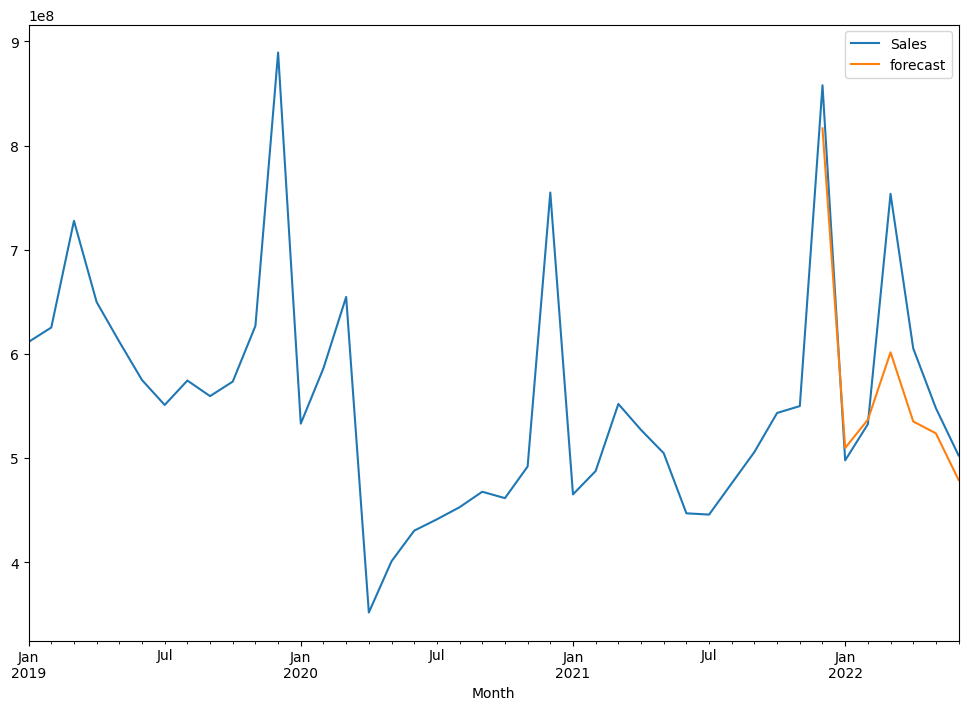

In [539]:
df[['Sales', 'forecast']].plot(figsize=(12,8))

As seen above, ARIMA did not predict it even a little bit closer. The reason behind this is when you have seasonal data ARIMA is not suitable. We will use SARIMAX which is Seasonal ARIMA, it is an extension of ARIMA.

## SARIMAX

SARIMAX is used on data sets that have seasonal cycles. The difference between ARIMA and SARIMAX is the seasonality and exogenous factors (seasonality and regular ARIMA don't mix well).

In [540]:
model = sm.tsa.statespace.SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))

In [554]:
results = model.fit()

In [555]:
df['forecast_SARIMAX'] = results.predict(start=20, end=42, dynamic=True)

In [556]:
df.tail(20)

,Sales,Sales first diff.,Seasonal first diff.,forecast,forecast_SARIMAX
Month,,,,,
2020-11-01,4.920891e+08,3.034795e+07,-1.349943e+08,NaN,4.981696e+08
2020-12-01,7.550166e+08,2.629275e+08,-1.343832e+08,NaN,7.224427e+08
2021-01-01,4.653435e+08,-2.896731e+08,-6.789488e+07,NaN,5.092177e+08
2021-02-01,4.877776e+08,2.243407e+07,-9.869116e+07,NaN,5.569276e+08
2021-03-01,5.521452e+08,6.436765e+07,-1.027008e+08,NaN,6.309547e+08
2021-04-01,5.271996e+08,-2.494566e+07,1.752391e+08,NaN,3.595793e+08
2021-05-01,5.048700e+08,-2.232959e+07,1.037366e+08,NaN,3.959949e+08
2021-06-01,4.471601e+08,-5.770991e+07,1.663631e+07,NaN,4.156593e+08
2021-07-01,4.459584e+08,-1.201634e+06,4.573786e+06,NaN,4.213687e+08


<Axes: xlabel='Month'>

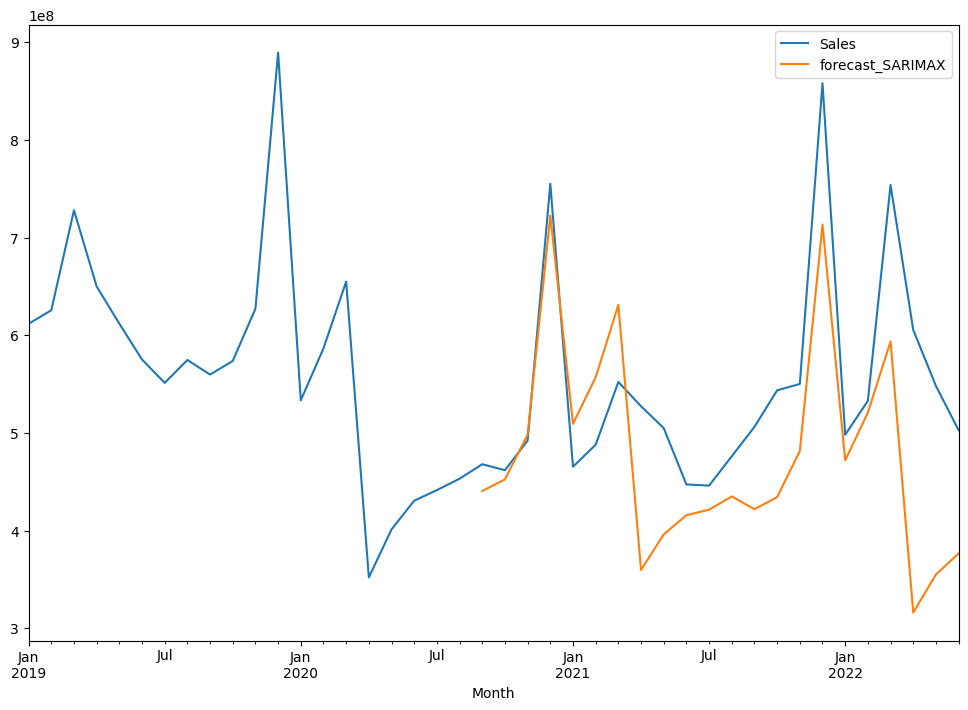

In [557]:
df[['Sales','forecast_SARIMAX']].plot(figsize=(12,8))

As seen above with the plot, SARIMAX was way better and closer to reality than ARIMA to predict sales.

## Making Predictions on Future Data with SARIMAX

Now we can use SARIMAX to forecast future data.

In [564]:
future_dates = [df.index[-1] + DateOffset(months=x)for x in range(0,3)]

In [565]:
future_dates[1:]

[Timestamp('2022-07-01 00:00:00'), Timestamp('2022-08-01 00:00:00')]

In [566]:
future_dataset = pd.DataFrame(index = future_dates[1:], columns = df.columns)

In [567]:
future_dataset.tail()

,Sales,Sales first diff.,Seasonal first diff.,forecast,forecast_SARIMAX
2022-07-01,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN


In [568]:
future_df = pd.concat([df, future_dataset])

In [569]:
future_df.shape

(44, 5)

In [570]:
future_df['forecast_SARIMAX2'] = results.predict(start=41, end=44, dynamic=True)

<Axes: >

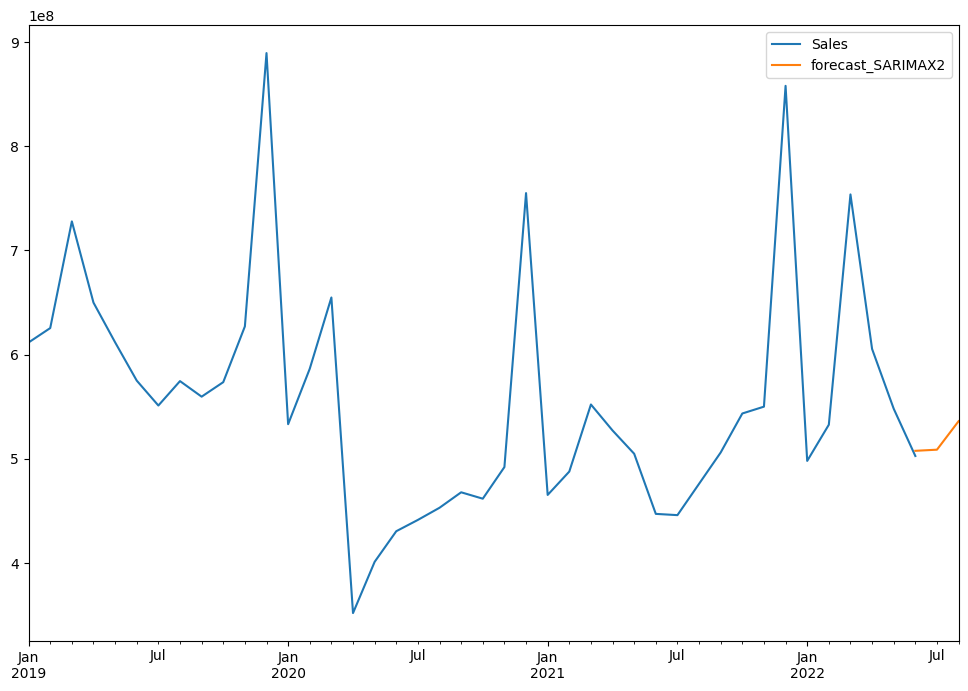

In [571]:
future_df[['Sales', 'forecast_SARIMAX2']].plot(figsize=(12,8))

The SARIMAX algorithm estimated the champagne sales for the years 1973 and 1974 as seen in the graph above.